In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
sns.set()


def isNewContainer(containerId):
    if containerId in knownIds:
        return "Reused"
    knownIds[containerId] = True
    return "New"

def percentile(n):
    def percentile_(x):
        return np.nanpercentile(x, n)
    percentile_.__name__ = 'p_%s' % n
    return percentile_

#constants
experiment_phase_length = 60000

labels = {
    "ibm": {
        "name": "ICF",
        "color": "cyan",
        "colorB": "darkcyan",
        "y-lim":5
    },
    "aws": {
        "name": "AWS",
        "color": "darkorange",
        "colorB": "brown",
        "y-lim":5
    },
    "gcf": {
        "name": "GCF",
        "color": "red",
        "colorB": "darkred",
        "y-lim":20
    },
    "azure": {
        "name": "MAF",
        "color": "blue",
        "colorB": "darkblue",
        "y-lim":200
    }
}

# Reading the results

In [9]:
#config
experiment_name = "test_m3"
providers = ["ibm","aws", "gcf", "azure"] 
num_repetitions = 5
configs = ["0,0,1","0,0,2","0,0,0.5","60,60,1","60,60,2","60,60,0.5"]
experiment_phase_labels = ['p0', 'p1', 'p2']

In [ ]:

knownIds = {}
all = None
for config in configs:
    for provider in providers:
        for run in range(1, num_repetitions+1):
            try:
                df = pd.read_csv('results/'+experiment_name+'/'+config+'/'+str(run)+'/'+provider+'.csv', skiprows = 0)

                df['provider'] = provider
                df['run'] = run
                df['config'] = config

                startTime = df['requestTime'].min()
                df['m1'] = df['requestTime']-startTime
                df['m2'] = df['executionStartTime']-startTime
                df['m3'] = df['executionEndTime']-startTime
                df['m4'] = df['responseTime']-startTime

                df['deliveryLatency']= (df['m2']-df['m1']) / 1000
                df['requestResponseLatency'] = df['requestResponseLatency'] / 1000
                df['executionLatency'] = df['executionLatency'] / 1000
                df['requestTime_normalized'] = df['requestTime'] - startTime
                df['requestTime_per30sec'] = df['requestTime_normalized'] // 30000 * 30
                df['requestTime_per5sec'] = df['requestTime_normalized'] // 100 / 10
                df['executionStartTime_normalized'] = df['executionStartTime'] - startTime
                df['experimentTime'] = df['requestTime_normalized'] // 1000
                df['executionStartTime_per30sec'] = df['executionStartTime_normalized'] // 30000 * 30
                df['executionStartTime_per5sec'] = df['executionStartTime_normalized'] // 100 / 10
                df['nonExecutionLatency'] = df['requestResponseLatency'] - df['executionLatency']
                df['label'] = df['requestTime_normalized'] // experiment_phase_length

                df['label'] = df['label'].apply(lambda x: experiment_phase_labels[min(x, len(experiment_phase_labels)-1)])

                df['newContainer'] = df['containerId'].apply(isNewContainer)
                df['failed'] = df['statusCode'] > 400

                df['executionLatencyNormalized'] = (df['executionLatency'] - df['executionLatency'].mean()) / df['executionLatency'].std()
                if (all is None):
                    all = df
                else:
                    all = pd.concat([all, df], sort=True)
            except OSError as e:
                print("Failed to read file for",provider,config,run)

all.head()



In [7]:
knownIds = {}
df = pd.read_csv('../benchmarkServer/results/mini_test/result-1567426529398.csv', skiprows = 0)
#df['provider'] = provider
#df['run'] = run

startTime = df['requestTime'].min()
df['m1'] = df['requestTime']-startTime
df['m2'] = df['executionStartTime']-startTime
df['m3'] = df['executionEndTime']-startTime
df['m4'] = df['responseTime']-startTime

df['deliveryLatency']= (df['m2']-df['m1']) / 1000
df['requestResponseLatency'] = df['requestResponseLatency'] / 1000
df['executionLatency'] = df['executionLatency'] / 1000
df['requestTime_normalized'] = df['requestTime'] - startTime
df['requestTime_per30sec'] = df['requestTime_normalized'] // 30000 * 30
df['requestTime_per5sec'] = df['requestTime_normalized'] // 100 / 10
df['executionStartTime_normalized'] = df['executionStartTime'] - startTime
df['experimentTime'] = df['requestTime_normalized'] // 1000
df['executionStartTime_per30sec'] = df['executionStartTime_normalized'] // 30000 * 30
df['executionStartTime_per5sec'] = df['executionStartTime_normalized'] // 100 / 10
df['nonExecutionLatency'] = df['requestResponseLatency'] - df['executionLatency']
#df['label'] = df['requestTime_normalized'] // experiment_phase_length

#df['label'] = df['label'].apply(lambda x: experiment_phase_labels[min(x, len(experiment_phase_labels)-1)])
#df['stabel'] = df['label'].isin(experiment_phase_groups['stable'])

df['newContainer'] = df['containerId'].apply(isNewContainer)
df['failed'] = df['statusCode'] > 400

df['executionLatencyNormalized'] = (df['executionLatency'] - df['executionLatency'].mean()) / df['executionLatency'].std()


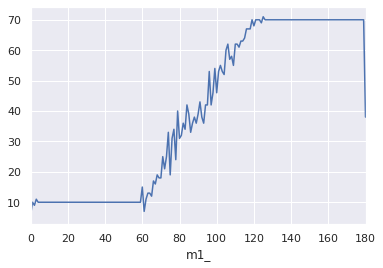

In [13]:

df['m1_'] = round(df['m1']/1000)
df.groupby('m1_')['m1_'].count().plot()

In [45]:
print(df[df['m1_'].between(0,60)]['m1_'].count()/60)
print(df[df['m1_'].between(60,120)]['m1_'].count()/60)
print(df[df['m1_'].between(120,180)]['m1_'].count()/60)

10.183333333333334
41.13333333333333
70.6


### Thrughput

In [3]:
phase_time = {'5':60000, '5 to 20':120000, '20':180000, '20 to 50':240000, '5(warm)':300000,'5 to 100':360000}
rows=["provider","phase","mean thr","target thr","relative thr???"]
colm = []
provider="gcf"
run = 2
for provider in providers:
    data = all[all['provider'] == provider]
    data = data[data['failed'] == False]
#     data = data[data["run"]==2]
    for phase in experiment_phase_labels:
        window = data[data["label"]==phase]
        lastSendInPhase=phase_time[phase]
        thr_mean = window[window['m4'] < lastSendInPhase]["m4"].count()/60.0/num_repetitions
        thr_target = window['m1'].count()/60.0/num_repetitions
        colm.append([provider,phase,"%.1f" %thr_mean,"%.1f" %thr_target,"%.1f" %((thr_mean*100)/thr_target)])
    
thr_qualities = pd.DataFrame(colm,columns=rows)
with open('./thr_per_phase.csv',"w") as f:
    f.write(thr_qualities.to_csv())
thr_qualities

,provider,phase,mean thr per sec,mean target per sec,relative thr???
0,ibm,5,4.9,5.0,96.9
1,ibm,5 to 20,11.9,12.5,95.3
2,ibm,20,19.4,20.0,97.3
3,ibm,20 to 50,33.4,34.8,95.9
4,ibm,5(warm),5.4,5.5,97.6
5,ibm,5 to 100,47.9,52.8,90.8
6,aws,5,4.6,5.0,91.7
7,aws,5 to 20,10.9,12.6,86.6
8,aws,20,18.2,20.0,91.3
9,aws,20 to 50,30.4,34.8,87.2


### Performance

In [4]:

rows=["provider","phase","median","90%","99%","max"]
colm = []
for provider in providers:
    data = all[all['provider'] == provider]
    data = data[data['failed'] == False]
#     data = data[data["run"]==2]
    for phase in experiment_phase_labels:
        window = data[data["label"]==phase]
        lastSendInPhase=phase_time[phase]
        window=window[window['m1'] < lastSendInPhase]['requestResponseLatency']
        colm.append([provider,phase,"%.2f" %window.quantile(0.5),"%.2f" %window.quantile(0.9),"%.2f" %window.quantile(0.99),"%.2f" %window.max()])
    
perf_qualities = pd.DataFrame(colm,columns=rows)
perf_qualities
with open('./perf_per_phase.csv',"w") as f:
    f.write(perf_qualities.to_csv())
perf_qualities

,provider,phase,median,90%,99%,max
0,ibm,5,1.62,2.01,3.07,6.55
1,ibm,5 to 20,1.63,2.01,2.79,3.84
2,ibm,20,1.62,1.98,2.84,6.15
3,ibm,20 to 50,1.63,2.05,3.38,7.53
4,ibm,5(warm),1.52,1.78,2.12,2.98
5,ibm,5 to 100,1.61,1.95,3.22,20.24
6,aws,5,5.48,6.25,7.15,7.67
7,aws,5 to 20,5.66,6.62,7.40,8.40
8,aws,20,5.63,6.46,7.32,7.85
9,aws,20 to 50,5.73,6.62,7.50,8.61


### Exec and NonExec Lat 

In [52]:
data = all
data = data[data['failed'] == False]
window =  data[['provider','label','nonExecutionLatency','executionLatency','deliveryLatency','newContainer']]
window['label']=window['label'].apply(lambda x: "phase %d"%(experiment_phase_labels.index(x)))
def _max(n):
    return np.max(n)
_max.__name__ = "max"
def _size(n):
    return len(n)
_size.__name__= "req. [#]"
foo = window.groupby(['provider','label','newContainer'])
exec_nonexec_lat = foo.agg([percentile(90), percentile(99),_max])
exec_nonexec_lat["req. [#]"] = foo["nonExecutionLatency"].agg([_size])
with open('./container_exec_nonexec_per_phase.csv',"w") as f:
    f.write(exec_nonexec_lat.to_csv())

style_map = exec_nonexec_lat.columns.get_loc_level('p_90', level=1)[0] | exec_nonexec_lat.columns.get_loc_level('p_99', level=1)[0] | exec_nonexec_lat.columns.get_loc_level('max', level=1)[0] 

cm = sns.light_palette("green", as_cmap=True)

exec_nonexec_lat.style.format("{:.2f}",subset=style_map)


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### Failed Requests

In [272]:
data = all
window =  data[['provider','label','failed']]
w = window.groupby(['provider','label','failed'])
w = w['failed'].count().reset_index(name="#")
total = w.groupby(['provider','label'])["#"].sum().reset_index(name="total")
def get(x):
    return int(total[(total['provider'] ==x['provider']) & (total['label'] == x['label'])].total)
w["failed req. [%]"] = w.apply(lambda x: x["#"]/get(x),axis=1)

with open('./failed_req.csv',"w") as f:
    f.write(w[w['failed']==True][["provider",'label',"failed req. [%]"]].to_csv())
failed_req = w
w[w['failed']==True][["provider",'label',"failed req. [%]"]]

,provider,label,failed req. [%]
7,azure,20,0.018021
9,azure,20 to 50,0.165798
11,azure,5,0.025845
13,azure,5 to 100,0.282351
15,azure,5 to 20,0.022909
17,azure,5(warm),0.016817


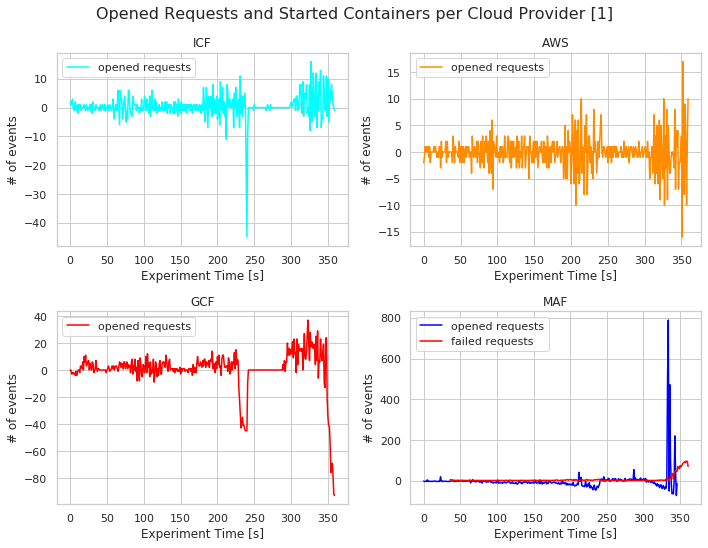

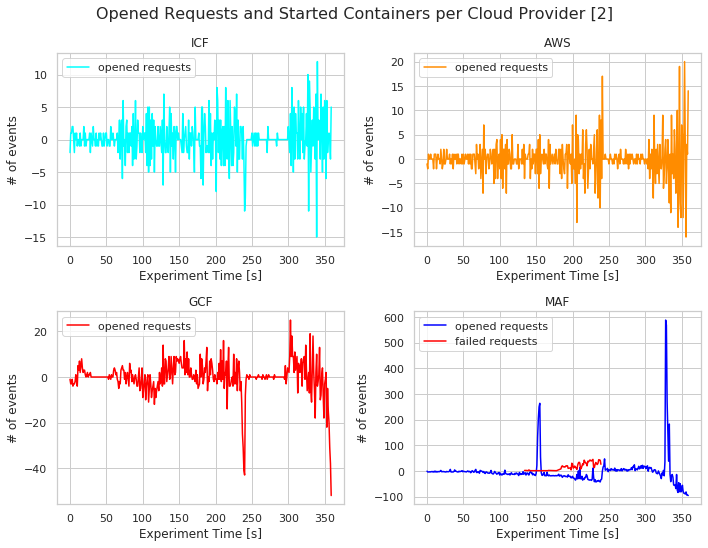

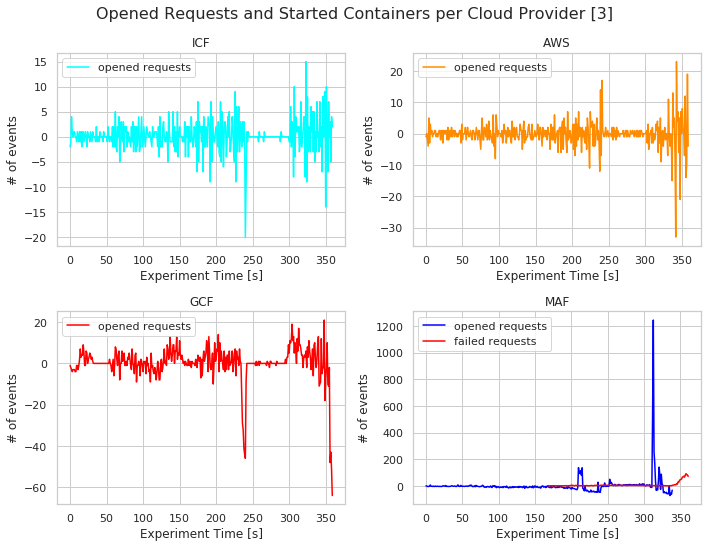

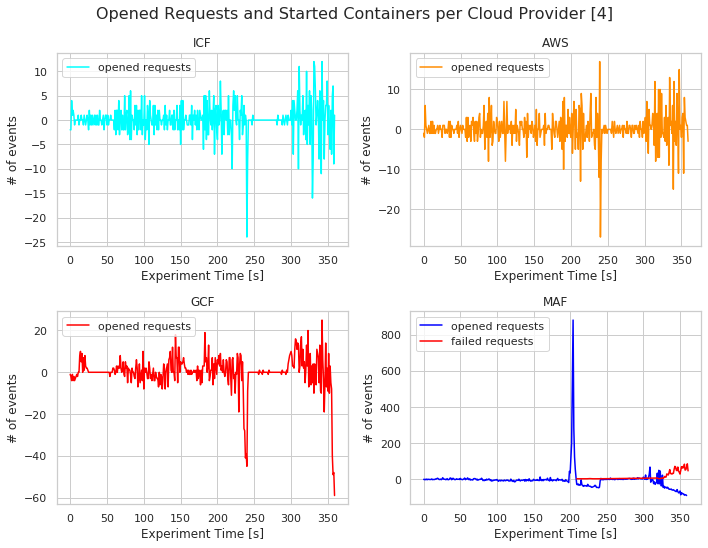

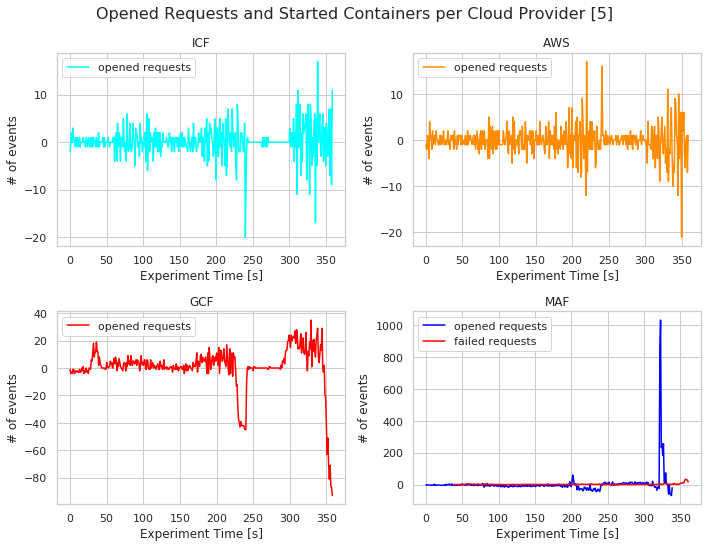

In [264]:

for run in range(1,6):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10.0, 8.0))
    plt.suptitle("Opened Requests and Started Containers per Cloud Provider [%d]"%run, fontsize=16)
    #plt.subplot(221)
    #ax = sns.boxplot(x="requestTime_per30sec", hue="provider", y="requestResponseLatency", data=all, palette="Set3", )
    #ax2 =  ax.twinx()
    #plt.subplot(412)
    plotId = 221
    for provider in providers:
        plt.subplot(plotId)
        plotId += 1
        data = all[all['provider'] == provider]
        data = data[data["run"]==run]
        data = data.sort_values(by="m1")
        data['m1_bucket']=round(data['m1']/1000)
        data['m2_bucket']=round(data['m2']/1000)
        A = data.groupby('m1_bucket')['m1'].count().reset_index(name='c')
    #     ax = sns.lineplot(x='m1_bucket', y='c', data=A, color=labels[provider]["color"], markers=True)
        B = data.groupby('m2_bucket')['m2'].count().reset_index(name='c')
    #     sns.lineplot(x='m2_bucket', y='c', data=B, color=labels[provider]["colorB"], markers=True)
        X = B.rename(columns={"m2_bucket":"x"})['c']-A.rename(columns={"m1_bucket":"x"})['c']
        X = X[0:360]
        ax = sns.lineplot( data=X, color=labels[provider]["color"], markers=True)

        failedExecutions = data[data['statusCode'] >= 400]
        C = failedExecutions.groupby('m1_bucket').size().reset_index(name='counts')
    #     failedExecutions = failedExecutions[['requestTime_per5sec', 'requestTime_normalized']].groupby(['requestTime_per5sec']).count().reset_index()
    #     failedExecutions['failures'] = failedExecutions['requestTime_normalized'].rolling(20, min_periods=1).mean() * 10
        sns.lineplot(x='m1_bucket', y='counts', data=C, color='red', markers=True)

        ax.legend(["opened requests", "failed requests"], loc='upper left')
    #     ax.set_xlim([0,380])
    #     ax.set_ylim([0,140])
        ax.set(xlabel='Experiment Time [s]', ylabel='# of events', title=labels[provider]["name"])


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

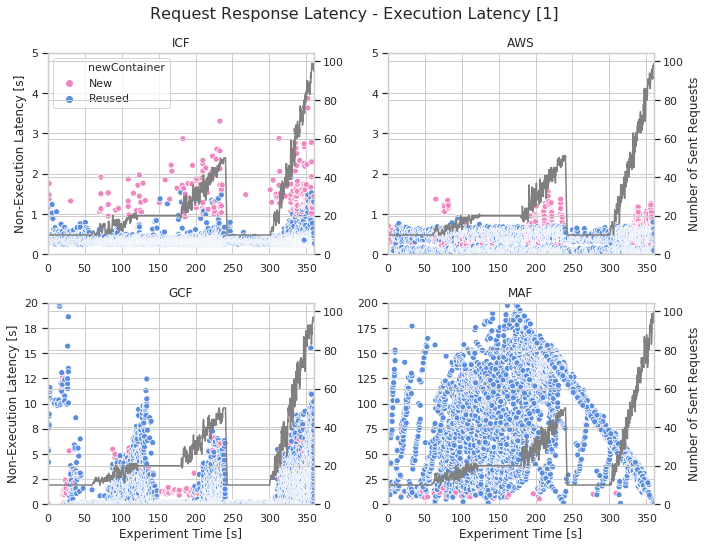

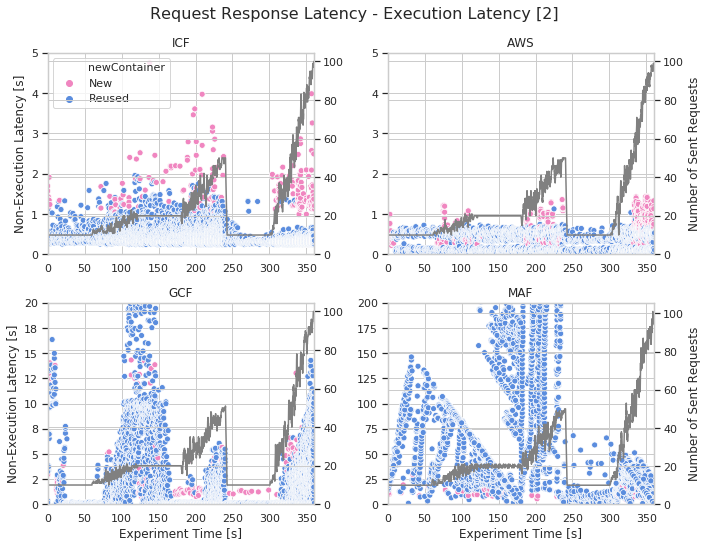

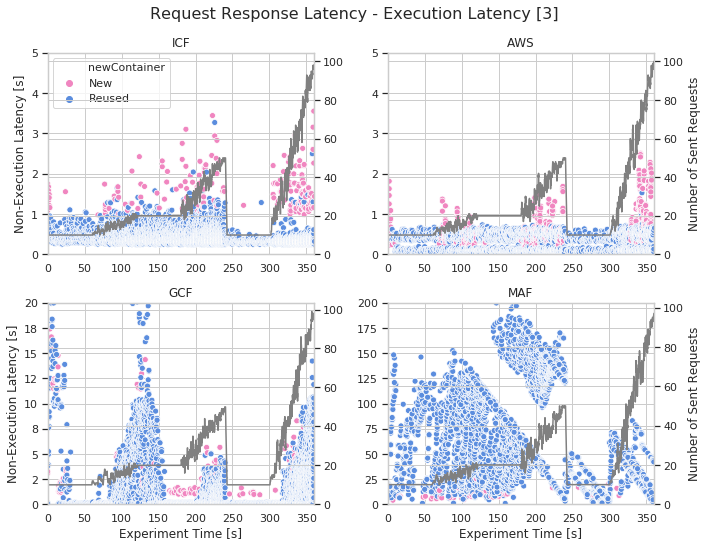

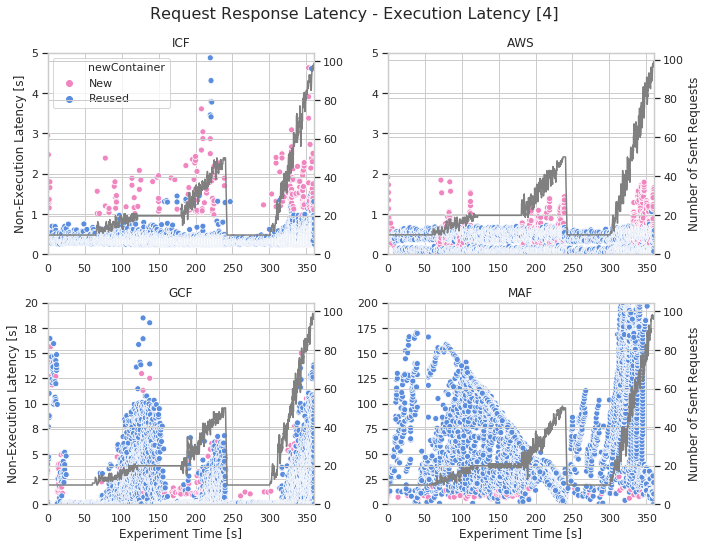

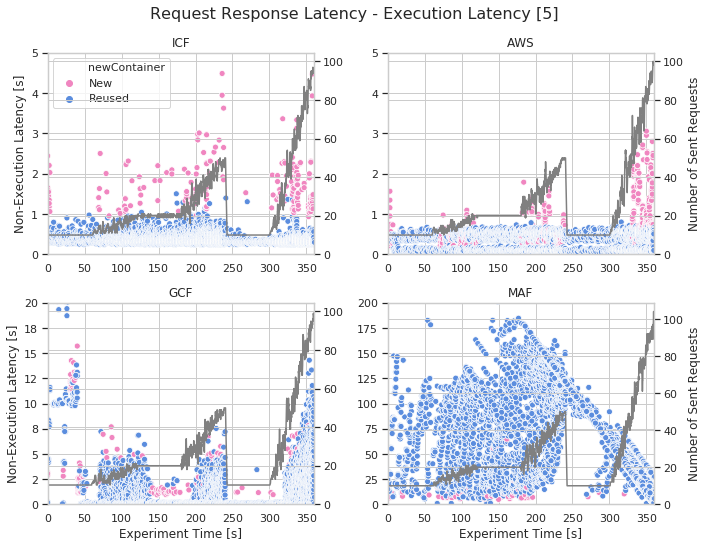

In [265]:
for run in range(1,6):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10.0, 8.0))
    plt.suptitle("Request Response Latency - Execution Latency [%d]"%run, fontsize=16)


    plotId = 221
    plot = 0
    for provider in providers:
        plt.subplot(plotId)
        plotId += 1
        plot+=1
        data = all[all["provider"] == provider]
        data = data[data["run"] == run]

        ax = sns.scatterplot(x="experimentTime", y="nonExecutionLatency", data = data, palette = {"New":"#f086c0","Reused":"#5b8dde"}, hue="newContainer")

        requestsPerSecond = data[['requestTime_per5sec', 'requestTime_normalized']].groupby(['requestTime_per5sec']).count().reset_index()
        requestsPerSecond['startedRequests'] = requestsPerSecond['requestTime_normalized'].rolling(10, min_periods=1).mean() * 10
        ax2 = ax.twinx()
        sns.lineplot(x='requestTime_per5sec', y='startedRequests', data=requestsPerSecond, color="gray", markers=True)

        ax.set_ylim(bottom=0,top=labels[provider]["y-lim"])
        ax.set_xlim(left=0, right=360)

        if plot == 1:
            ax.legend(loc='upper left')
        else:
            ax.get_legend().remove()

        ax2.set_ylim(bottom=0)
        ax2.set_xlim(left=0)

        if plot > 2:
            ax.set(xlabel='Experiment Time [s]', title=labels[provider]["name"])
        else:
            ax.set(xlabel='', title=labels[provider]["name"])

        if plot%2 ==1:
            ax.set(ylabel='Non-Execution Latency [s]')
            ax2.set(ylabel='')
        else:
            ax.set(ylabel='')
            ax2.set(ylabel='Number of Sent Requests')
        ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: "{0:.0f}".format(x)))    



    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

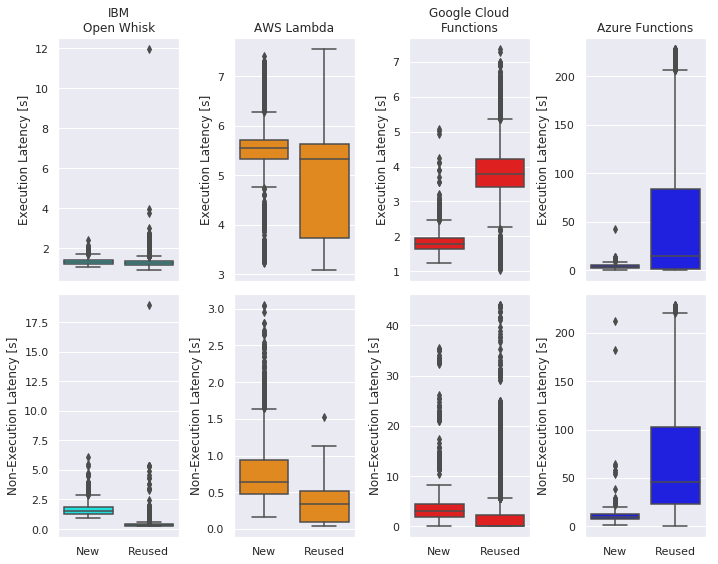

In [46]:
plt.figure(figsize=(10,8))
pltId = 1
for provider in providers:
    plt.subplot(2, 4, pltId)
    data = all[all["provider"] == provider]
    ax = sns.boxplot(x="newContainer", y="executionLatency", color=labels[provider]["color"], data = data)
    ax.set(ylabel='Execution Latency [s]', xlabel="", title=labels[provider]["name"])
    ax.get_xaxis().set_ticks([])
    plt.subplot(2, 4, pltId+4)
    ax2 = sns.boxplot(x="newContainer", y="nonExecutionLatency", color=labels[provider]["color"], data = data)
    pltId += 1
    ax2.set(ylabel='Non-Execution Latency [s]', xlabel="")
    ax2.get_xaxis().labelpad = 20
plt.tight_layout()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

plt.savefig("Container1.pdf")

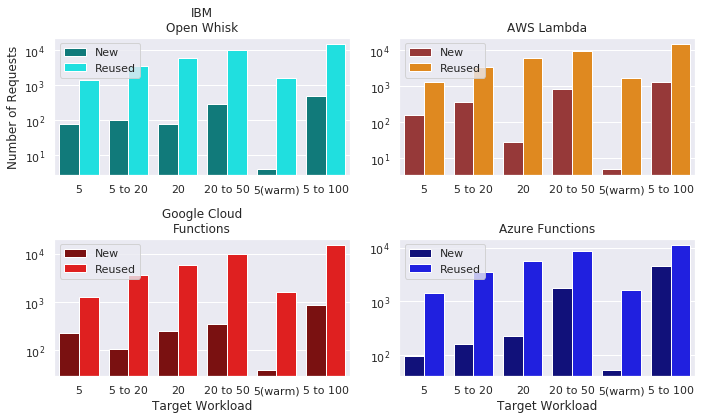

In [38]:
plt.figure(figsize=(10,6))
pltId = 1
for provider in providers:
    plt.subplot(2, 2, pltId)
    ax = sns.countplot(x="label", hue="newContainer", data = all[all["provider"] == provider], palette=[labels[provider]["colorB"], labels[provider]["color"]])
    #ax.set_ylim(0, 18000)
    ax.set_yscale("log")
    ax.set(title=labels[provider]["name"])
    if pltId == 1:
        ax.set(ylabel="Number of Requests", xlabel="")
    elif pltId >= 3:
        ax.set(ylabel="", xlabel="Target Workload")
    else:
        #ax.get_yaxis().set_ticks([])
        ax.set(ylabel="", xlabel="")
    pltId += 1
    ax.legend(["New", "Reused"], loc='upper left')

plt.tight_layout()
plt.savefig("Container2.pdf")

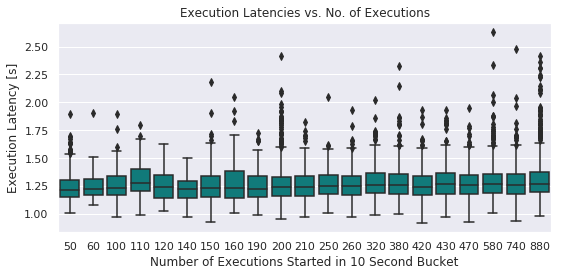

In [26]:


experiment_name = "big_experiment"
providers = ["ibm"] 
num_repetitions = 5
experiment_phase_length = 60000
experiment_phase_labels = ['5', '5 to 20', '20', '20 to 50', '5(warm)','5 to 100']
all = None
for provider in providers:
    for run in range(1, num_repetitions+1):
        df = pd.read_csv('../benchmarkServer/results/'+experiment_name+'/'+str(run)+'/'+provider+'.csv', skiprows = 0)
        df['provider'] = provider
        df['run'] = run
        startTime = df['requestTime'].min()
        df['requestResponseLatency'] = df['requestResponseLatency'] / 1000
        df['executionLatency'] = df['executionLatency'] / 1000
        df['requestTime_normalized'] = df['requestTime'] - startTime
        df['requestTime_per5sec'] = df['requestTime_normalized'] // 5000 * 5
        df['executionStartTime_normalized'] = df['executionStartTime'] - startTime 
        df['experimentTime'] = df['requestTime_normalized'] // 1000
        df['executionStartTime_per30sec'] = df['executionStartTime_normalized'] // 30000 * 30
        df['executionStartTime_per5sec'] = df['executionStartTime_normalized'] // 10000 * 10
        df['nonExecutionLatency'] = df['requestResponseLatency'] - df['executionLatency']
        df['label'] = df['requestTime_normalized'] // experiment_phase_length
        df['label'] = df['label'].apply(lambda x: experiment_phase_labels[min(x, len(experiment_phase_labels)-1)])

        df['executionLatencyNormalized'] = (df['executionLatency'] - df['executionLatency'].mean()) / df['executionLatency'].std()
        if (all is None):
            all = df
        else:
            all = pd.concat([all, df])

data = df#[df["provider"] == "aws"]

data["startedExecutionsPer5Seconds"] = data.groupby("executionStartTime_per5sec")['executionStartTime_per5sec'].transform('count').round(-1)
plt.figure(figsize=(8,4))
ax = sns.boxplot(x="startedExecutionsPer5Seconds", y="executionLatency", data = data, color="darkcyan")
ax.set(xlabel='Number of Executions Started in 10 Second Bucket', ylabel='Execution Latency [s]', title="Execution Latencies vs. No. of Executions")

plt.tight_layout()
plt.savefig("ibm.pdf")